# 4. Time Series Analysis

Eventhough we cover time series analysis models here, it is not a good idea to use them for financial analysis. Time series analysis models are useful for other fields, though.

Overview of contents:
1. Time series basics
2. Statsmodels library
3. EWMA models
4. ETS models and decomposition
5. ARIMA models

## 4.1 Time Series Basics

Properties of time series:
- Value that changes over time: (time point, value)_t
- **Trends**: on average, after filtering, what is the value doing? The mean is taken for a period: Mooving Average
    - Upward
    - Horizontal/Stationary
    - Downward
- **Seasonality**: repeating trend, periodic trends, related in origin to the seasons
    - Example: google trend for "snowboarding" peaks every winter
- **Cyclical trends**: trends repeat but there is no fixed seasonality, ie., we cannot say when the pattern is going to repeat
    - Example: SP-500 over 20-30 years seems to have repetitive patterns upwards, but there no clear or fixed frequency or seasonality properties

## 4.2 Introduction to Statsmodels

- Very popular for time series in python
- `statsmodels` is hevaily inspired by `R`
- Installation: `conda install statsmodels`
- Very good documentation with notebook examples online
    - [https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)
    - [https://www.statsmodels.org/stable/examples/index.html#time-series-analysis](https://www.statsmodels.org/stable/examples/index.html#time-series-analysis)

**WARNING**: I had some nasty issues trying to import `statsmodels`. I think the caus is linked to two factors:
1. My Anaconda installation seems messed up, I probably need to take one morning free for fixing it, ie., re-installing everything...
2. Jupyter was not installed in the `pyfinance` environment, thus the jupyter from another environment was being taken; that caused incompatibilities due to old versions.

After installing jupyter in the used environment I had to fix another issue of missing library with some nasty commands, which are not really a fix, but a botcher:
```bash
cd ~/anaconda3/envs/pyfinance/lib
ln -is libffi.dylib libffi.6.dylib
```

Conclusion: I need to uninstall Anaconda and re-install it again to fix everything.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# That is how statsmodels is always imported
import statsmodels.api as sm

In [9]:
# We have several datasets to work with
# We can load them with sm.datasets.TAB
# macrodata is a dataset about USA economic data
# .load_pandas().data yields the dataframe
# .NOTE yields a docu string
df = sm.datasets.macrodata.load_pandas().data

In [10]:
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [11]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [16]:
# We have quarter data from 1959 to 2009 (look at head & tail)
# We can arrange rows with quarter end data
# and make those dates be the index
# statsmodels has a functionality for that, but we could do it with pandas, too
index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1','2009Q3'))

In [17]:
df.index = index

In [18]:
df

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-12-31,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-03-31,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-06-30,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Text(0, 0.5, 'Real GDP')

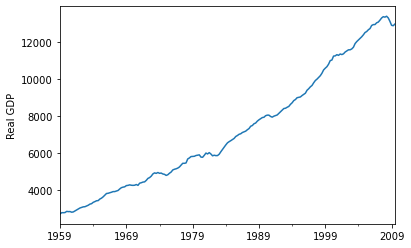

In [20]:
df['realgdp'].plot()
plt.ylabel('Real GDP')

### Trend and Cycle with Hodrick-Prescott
The Hodrick-Prescott filter separates a time-series $y_t$ into a trend $\tau_t$ and a cyclical component $\zeta_t$ (and the error or residual $\epsilon_t$):

$y_t = \tau_t + \zeta_t \,\,\,(+\,\, \epsilon_t)$

The components are determined by minimizing the following quadratic loss function

$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$

Wikipedia: [https://en.wikipedia.org/wiki/Hodrick–Prescott_filter](https://en.wikipedia.org/wiki/Hodrick–Prescott_filter)

In [66]:
# We can use the Hodrick-Prescott filter in statsmodels
# to obtain the trend and the cyclical components
# The tsa package stands for 'time series analysis'
# Note that we need to pass a lambda value (see Wikipedia)
# lamb = 1600, quarterly data (default)
# lamb = 6.25, annual data
# lamb = 129600, monthly data
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df['realgdp'])

In [22]:
df['trend'] = gdp_trend
df['cycle'] = gdp_cycle

<AxesSubplot:>

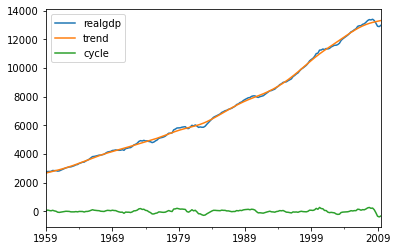

In [23]:
df[['realgdp','trend','cycle']].plot()

<AxesSubplot:>

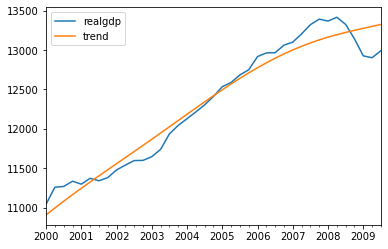

In [27]:
# A closer look
df[['realgdp','trend']]['2000-03-31':].plot()

## 4.3 EWMA Models = Exponentally Weighted Moving Averages

If we apply **simple moving averages** to a time series we can get the trend and seasonality components if the appropriate averaging window is chosen:
- The larger the window, the more clear is the trend
- For small windows redisual/error is removed and the seasonality lower frequency component is visible
- BUT we have some problems:
    - we add a delay/lag to the filtered series (of the size of the window)
    - smaller windows will lead to more noise rather than signal
    - due to the averaging, it will never reach a full peak/valley
    - no information about the future given
    - extreme historical values skew the SMA significantly
- The **exponentially weighted moving average** alleviates those issues!

**Exponentially weighted moving averages (EWMA)** reduce the lag and put more weight on recent events.

Simple moving average with window size $n$:

$s_t (n) = \frac{1}{n} (x_{t} + x_{t-1} + \ldots + x_{t-n-1})$

Exponential moving average with window size $n$: it is equivalent to the SMA, but we multiply the $x_{t}$ with an exponentially decaying weight $w$ (w_{i} > w_{i-1}) as we go back in time from the present. The sum of all weights is supposed to be 1, so the exponent coefficient is adjusted for matching that given the window size:

$ s_t = \frac{\sum\limits_{i=0}^{n-1} w_i x_{t-i}}{\sum\limits_{i=0}^{n-1} w_i}$

As shown on Wikipedia, this is equivalent to performing the following with a correctly selected factor $\alpha$ matching with the window size:

$s_t = s_{t-1} + \alpha (x_t - s_{t-1}) $

The factors od $\alpha$ and $w$ are equivalent and their relationship is the following:

\begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

In practice, several equivalent single parameters can be used for describing the EWA:

- the alpha $\alpha$ smoothing factor
- the **span** $s$ **= window** (that is the easiest one to understand)
- the center of mass $c$, realted to the cneter of the weight distribution
- and the half-life $h$, the period of time for the exponential weight to reduce to one half

They are related as follows:

$\alpha = \frac{2}{s+1}$

$\alpha = \frac{1}{1+c}$

$\alpha = 1 - \exp^{\frac{\log 0.5}{h}}$



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# We need to set the index to be the time data, in this case the month
airline = pd.read_csv('data/airline_passengers.csv',index_col='Month')

In [38]:
# We need to drop all unknown/missing values
airline.dropna(inplace=True)

In [45]:
# The index needs to be converted from string to datetime
airline.index = pd.to_datetime(airline.index)

In [46]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [43]:
# Now, the first tday of the month is our time point for each month
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<AxesSubplot:xlabel='Month'>

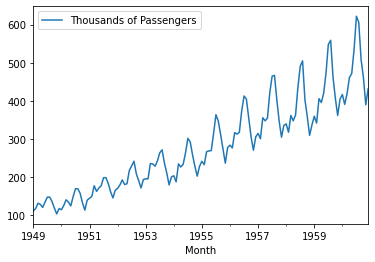

In [44]:
# Plot
airline.plot()

In [51]:
# We compute simple moving averages
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

<AxesSubplot:xlabel='Month'>

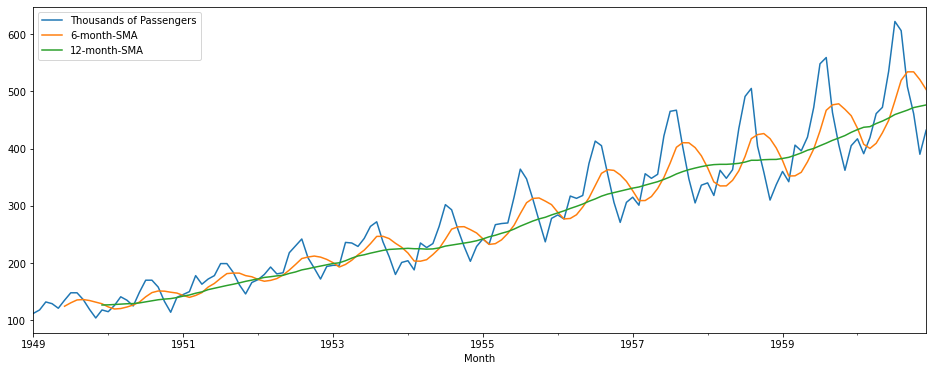

In [53]:
# When we plot we see that
# 12 month SMA removed oscillations leaving a clear upward trend
# 6 month SMA removed residual and left clear oscillations around the trend
# Conclusions:
# - seasonality should be due to year seasons (holidays, weather), being the period around 6 months
# - after applying a MA beyond that period we get the real trend
airline.plot(figsize=(16,6))

In [54]:
# We compute exponentially moving averages with .ewm().mean()
# We can pass several one-variable definitions: com, span, alpha (look at docs)
airline['12-month-EMA'] = airline['Thousands of Passengers'].ewm(span=12).mean()

<AxesSubplot:xlabel='Month'>

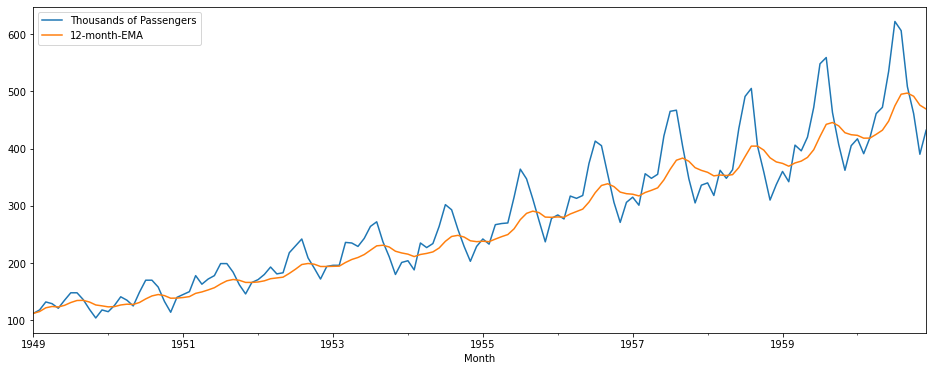

In [57]:
# Plot
# We see that we fix the issues present in SMA: lag is reduced, etc. (see above)
airline[['Thousands of Passengers','12-month-EMA']].plot(figsize=(16,6))

## 4.4 ETS Models and Decomposition = Error-Trend-Seasonality

ETS models are a family of exponential smoothing filters able to extract the trend, seasonality and error components of a time series. Given the real time series $x_t$, the exponentially smoothened series $s_t$ would be:

$s_0 = x_0$

$s_t = \alpha x_t + (1 - \alpha)s_{t-1}$

We perform a **time series decomposition** (= **ETS decomposition**) to a time series in order to break down the series to those three components: **error (residual)**, **trend**, and **seasonality**. The visualization of the components is usually very informative of what's happening to he series.

Example diagram shown: Number of passengers of arilines from 1959 to 2010. We see there is a clear upward trend and seasonality effects.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
# We need to set the index to be the time data, in this case the month
airline = pd.read_csv('data/airline_passengers.csv',index_col='Month')

In [60]:
# We need to drop all unknown/missing values
airline.dropna(inplace=True)

In [61]:
# The index needs to be converted from string to datetime
airline.index = pd.to_datetime(airline.index)

<AxesSubplot:xlabel='Month'>

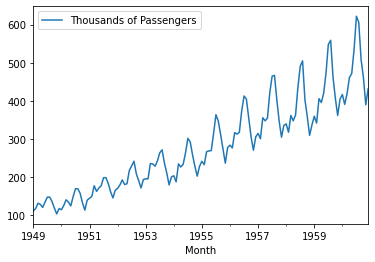

In [63]:
# We plot the curve again
# We notice we have clear trend and seasonality components
# We want to separate them, and additionally,
# we want to see if the trend increases linearly o exponentially
airline.plot()

In [67]:
# We load the decompositionutility from the time series analysis package (tsa)
from statsmodels.tsa.seasonal import seasonal_decompose

In [68]:
# We can choose between additive and multiplicative models
# additive: when trend seems to grow linearly
# multiplicative: when trend seems to grow faster than linearly -> exponentially?
# the result has several outputs, we can explore them with result.TAB
# - seasonal
# - trend
# - resid
# ...
# - result.plot() plots them all!
result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')

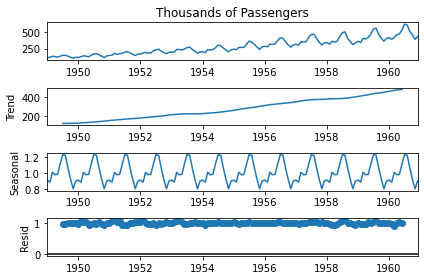

In [76]:
result.plot(); # ; to avoid dual plot, which is a bug in statsmodels

<AxesSubplot:xlabel='Month'>

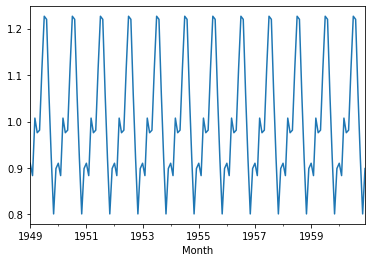

In [77]:
# We can also plot individdual compoenents: seasonal, trend, etc.
result.seasonal.plot()

<AxesSubplot:xlabel='Month'>

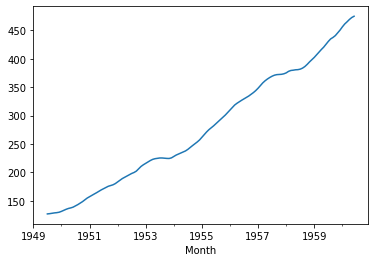

In [78]:
result.trend.plot()

## 4.5 ARIMA Models = Auto-Regressive Integrated Moving Average

ARIMA models do not work well with historical stock or similar financial data, but they are one of the most known and fudamental models for time series analysis.

However, they work very well with other data, such as sales predictions, etc.

ARIMA models can get very complex.

ARIMA models are a generalization of ARMA models
- ARIMA = Auto-Regressive Integrated Moving Average
- ARMA = Auto-Regressive Moving Average

Two types of ARIMA:
- Non-seasnal ARIMA
- Seasonal ARIMA

**Non-seasonal ARIMA: models denoted as ARIMA(p,d,q)**, being all p-d-q positive integers:
- p, AR = Auto-Regression component: Regression between current observation and observations over a previous period
- d, I = Integrated component: differencing of observations in order to make series stationary: subtracting the previous observation to the current
- q, MA = Moving Average component: dependency between an observation and a residual error from a moving average applied to lagged observations

**Stationary vs Non-Stationary**
- A stationary series has a constant mean and variance over time
    - note that the the covariance must be also constant: oscillations cannot the compressed in any spot over time
- A non-stationary series as either or both mean and variance changing over time
    - note that if a series has a non-constant covariance it is considered non-stationary
- Usually, we do not check stationarity visually, but we perform a test, e.g., the Dickey-Fuller test with `statsmodels`
- If we hav a non-stationary series, we need to convert it stationary in order to evaluate what type of ARIMA model to use
    - One way of doing that is differencing: to each value at t, we substract the vakue at t-1
    - If that first difference does not make the series stationary, we do more differences until data is stationary; drawback: every differencing removes a row
    - For seasonal data, we can difference by season: for month data that would be a time unit of 12: `.shift(12)`

**Auto-Correlation Plots** (ACF) for choosing the correct `p,d,q` values:
- Autocorrelation plot = correlogram
- Correlation of the series with itself lagged n units:
    - x axis is the n units of lag
    - y axis is the correlation
- Typically there are two types of autocorrelation plots:
    - Gradual decline
    - Sharp dropoff after first lag unit
    
ARIMA: Chossing the components AR
- We can take either the AR or MA components, or less frequently, both AR + MA
    - With AR and MA we set the values p (AR) and q (MA)
- If ACP shows
    - **positive** correlation after the first lag: use **AR**
    - **negative** correlation after the first lag: use **MA**
- Values for `p,d,q`:
    - `p`: number of observations
    - `d`: number of times the observations were differenced
    - `q`: size of the moving average window = order of MA

**Partial Auto-Correlation Functions** (PACF):
- A partial correlation is a conditional correlation
- Correlation between 2 variables under the assumption we know and consider another set of variables (??)
- If we see
    - a sharpe decline after lag k, use AR-k model
    - a gradual decline, use MA model
- In general
    - an AR model is best identified with PACF
    - an MA model is best identified with ACF
    
There is also the seasonal ARIMA, which is equivalent, but we use capital parameters `P,D,Q`.

### General steps for ARIMA models

1. Load and clean up data
2. Visualize the Time Series Data
3. Make the time series data stationary
4. Plot the Correlation and Auto-Correlation charts
5. Construct the ARIMA model
6. Use the model to make predictions

### 4.5.1 Load and clean up the data

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
import statsmodels.api as sm

In [103]:
df = pd.read_csv('data/monthly-milk-production-pounds-p.csv')

In [104]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [105]:
# Fix the column names
df.columns = ['Month', 'Milk in Pounds per Cow']

In [106]:
df.tail()

,Month,Milk in Pounds per Cow
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [107]:
# Drop last row, because it's weird
df.drop(168,axis=0,inplace=True)

In [108]:
# Convert month column from string to datetime
df['Month'] = pd.to_datetime(df['Month'])

In [109]:
# Now, the first day of the month is in the column Month
df.head()

,Month,Milk in Pounds per Cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [110]:
# Set the index to be the Month column
df.set_index('Month',inplace=True)

In [112]:
df.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [114]:
# Get descriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


### 4.5.2 Visualize the time series data

<AxesSubplot:xlabel='Month'>

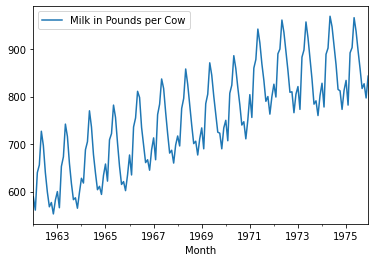

In [116]:
# We can see in the plot the trend upwards and the seasonality
df.plot()

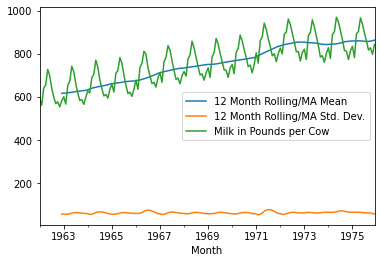

In [118]:
# We can manually decompose the trend and the seasonality
# The plot below is typical for seasonal data
# - a 12 month rolling yields the trend
# - std. dev. is typically much smaller than the trend and constant (with noise)
time_series = df['Milk in Pounds per Cow']
time_series.rolling(12).mean().plot(label='12 Month Rolling/MA Mean')
time_series.rolling(12).std().plot(label='12 Month Rolling/MA Std. Dev.')
time_series.plot()
plt.legend()

In [120]:
# We can also use tools from statsmodels for series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

In [122]:
# Note that we can pass more params, look with shift+TAB or in docu
# For example: additive/multiplicative, if no pandas data we must pass period,
# which is the number of elements in a row after which a cycle re-starts,
# in our case: period = 12 (months)
decomp = seasonal_decompose(time_series)

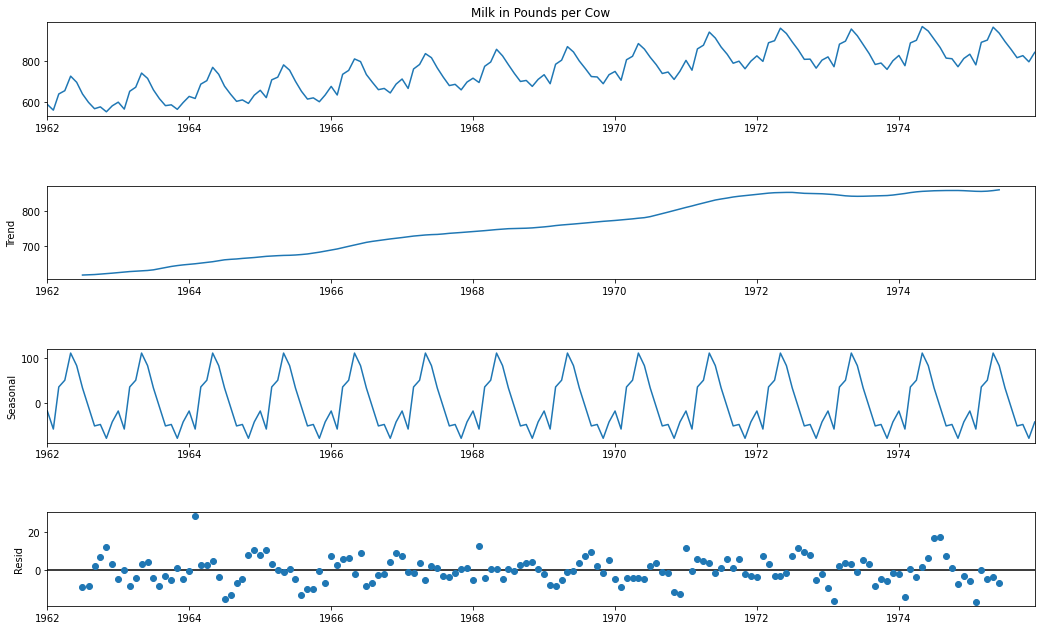

In [132]:
fig = decomp.plot()
fig.set_size_inches(16,10)

### 4.5.3 Test and fix the stationarity